In [1]:
__nbid__ = '0072'
__author__ = 'Alice Jacques <alice.jacques@noirlab.edu>'
__version__ = '20250303' # yyyymmdd; 
__datasets__ = ['skymapper_dr4', 'gaia_dr3', 'sdss_dr17']
__keywords__ = ['science example', 'crossmatch', 'LMC', 'photometry', 'plot:cmd', 'stars']

# Searching for extremely metal-poor stars in the Large Magellanic Cloud
*Alice Jacques*

### Table of contents
* [Goals & notebook summary](#Goals)
* [Disclaimer & attribution](#Disclaimer-&-attribution)
* [Imports & setup](#Imports-and-setup)
* [Authentication](#Authentication)
* [Query for EMP candidates in SkyMapper DR4, Gaia DR3, and APOGEE-2](#Query-for-EMP-candidates-in-SkyMapper-DR4,-Gaia-DR3,-and-APOGEE-2)
* [Object selection differences in the paper vs. this notebook](#Object-selection-differences-in-the-paper-vs.-this-notebook)
* [Metallicity-sensitive diagram and CMD](#Metallicity-sensitive-diagram-and-CMD)
* [Radial velocity vs. position angle](#Radial-velocity-vs.-position-angle)
* [Resources and references](#Resources-and-references)

# Goals
The goal of this notebook is to replicate the investigation done in the paper [Oh et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.524..577O/abstract) to find extremely metal-poor (EMP) stars $([Fe/H] \le -3.0)$ in the Large Magellanic Cloud (LMC) using the latest [SkyMapper](https://skymapper.anu.edu.au/) data release SkyMapper DR4 (the paper uses DR3). We follow the same steps and apply the same data constraints as Oh et al. 2023 by using SkyMapper photometry, parallax and proper motion cuts from [Gaia](https://www.esa.int/Science_Exploration/Space_Science/Gaia), color-magnitude cuts, and a metallicity-sensitive cut. We then obtain the radial velocity values from [APOGEE-2](https://www.sdss4.org/surveys/apogee-2/) for our candidates and compare them to the LMC rotation curve to confirm their Magellanic membership. This notebook uses our own publicly available tables hosted at Astro Data Lab.

# Summary

In [Oh et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.524..577O/abstract), the authors present results of a search for extremely metal-poor (EMP) stars in the Large Magellanic Cloud (LMC), which can provide crucial information about the properties of the first stars as well as on the formation conditions prevalent during the earliest stages of star formation in dwarf galaxies. Their search utilized SkyMapper DR3 photometry, parallax and proper motion cuts from Gaia, color-magnitude cuts (by selecting the red giant branch region), and a metallicity-sensitive cut. To confirm the EMP status of their photometric candidates, they obtained low-resolution spectra using the ANU 2.3m telescope/WiFeS spectrograph combination, from which seven stars with $[Fe/H] \le −2.75$ were identified, including two with $[Fe/H] \le −3$. Radial velocities, derived from the Ca II triplet lines, generally match well with the outer rotation curve of the LMC for the candidates in their sample, confirming that their targets are probable LMC members. Their results constitute the most metal-poor stars found so far in the LMC.

# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

# Imports and setup

In [2]:
# Standard lib
from getpass import getpass

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data Lab
from dl import authClient as ac, queryClient as qc

# plots and pandas default setup
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', None)

# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [3]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'ajacques'

# Query for EMP candidates in SkyMapper DR4, Gaia DR3, and APOGEE-2
Our query will search for possible EMP candidates in the LMC using data from the [**skymapper_dr4.master**](https://datalab.noirlab.edu/query.php?name=skymapper_dr4.master), [**gaia_dr3.gaia_source**](https://datalab.noirlab.edu/query.php?name=gaia_dr3.gaia_source), and [**sdss_dr17.apogee2_allstar**](https://datalab.noirlab.edu/query.php?name=sdss_dr17.apogee2_allstar) tables. Column definitions for each table can be found at the corresponding links in the previous sentence.

#### We will search for objects in the **skymapper_dr4.master** table with the following constraints:
- $class\_star > 0.9$
    > to ensure that the object is stellar in nature ([Wolf et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASA...35...10W/abstract))
- $flags \le 3$
    > so that there are no apparent issues with the [SExtractor](https://sextractor.readthedocs.io/en/latest/index.html) photometry ([Wolf et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASA...35...10W/abstract))
- $v\_ngood \ge 2$
    > to ensure at least two measurements in the v-band ([Wolf et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASA...35...10W/abstract))
- $g\_psf \le 16.5$
    > so that the LMC candidates can be observed at high dispersion on 8m-class telescopes with sensible integration times ([Oh et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.524..577O/abstract))
- $e\_g\_psf < 0.03$, $e\_i\_psf < 0.03$, and $e\_v\_psf < 0.05$ mag
    > as a compromise between photometric precision and number of candidates selected ([Wolf et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASA...35...10W/abstract))
- $ebmv\_sfd < 0.25$ mag
    > to avoid large reddening corrections to the photometry and to avoid areas of the sky where the photometry is less well calibrated and frequently affected by image crowding ([Da Costa et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.489.5900D/abstract))
- $5 \le \cos^{-1}(\sin(\delta)\sin(\delta_{c}) + \cos(\delta)\cos(\delta_{c})\cos(\alpha-\alpha_{c})) \le 20$
    > limit to a region that is 5 deg to 20 deg in radius from the LMC center (to avoid crowding in the inner parts of the dwarf galaxy), where $\delta_{c} = -69.78$ deg and $\alpha_{c} = 81.28$ deg is the center of the LMC ([Oh et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.524..577O/abstract))
- $m_{i} \ge -0.2$
    > metallicity index cut using the metallicity-sensitive index: $m_{i} = (v − g)_0 − 1.5(g − i)_0$ (since previous studies have shown that stars with metallicity indices more negative than this value are often young stars with Ca II H+K emission, or extragalactic objects such as quasi-stellar objects and active galactic nuclei ([Da Costa et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.489.5900D/abstract)))
- $0.7 \le (g-i)_0 \le 1.2$
    > since the RGB at lower metallicities ($[Fe/H] \le -2.5$) does not go beyond $(g-i)_{0} \sim 1.2$ mag for an old age ($\gtrsim 10$ Gyr) population. The blue color cut is applied because we want to avoid contamination from young approximately solar metallicity disc dwarfs in the bluer parts of the CMD ([Oh et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.524..577O/abstract))
- $self\_dist2 > 7.5$ and $gaia\_dr3\_dist2 > 7.5$
    > so that there is no other SkyMapper DR4 or additional Gaia DR3 source within 7.5 arcsec of the target ([Wolf et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASA...35...10W/abstract))

#### Then crossmatch with the **gaia_dr3.gaia_source** table with the following constraints:
- $-0.2'' \le \pi \le 0.2''$
    > parallax between -0.2'' and 0.2'' ([Oh et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.524..577O/abstract))
- $\sqrt{1.7(\mu_{\alpha} - 1.80)^{2} + 0.8(\mu_{\delta} - 0.37)^{2}} \le 1.0$
    > this equation was determined quantitatively, where they measured the average proper motion and spread for stars located 2 deg - 6 deg from the LMC center (to avoid kinematics from the core and contamination from the Milky Way Halo) ([Oh et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.524..577O/abstract))

#### Finally, join our objects with the **sdss_dr17.apogee2_allstar** table to obtain the radial velocity, effective temperature, logg, and FeH values

In [4]:
query = """
SELECT
    s.object_id, s.gaia_dr3_id1 AS gaia_id, s.raj2000 AS ra, s.dej2000 AS dec, s.radius,
    (ATAN((81.28*(PI()/180) - s.raj2000*(PI()/180))/(-69.78*(PI()/180) - s.dej2000*(PI()/180))))*(180/PI()) AS angle,
    (s.g_psf - 2.986 * s.ebmv_sfd) AS g0, ((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd) AS g_i0, s.ebmv_sfd,
    (((s.v_psf - s.g_psf) - 1.04 * s.ebmv_sfd) - 1.5*((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd)) AS metallicity,
    a.rv_teff, a.rv_logg, a.rv_feh, a.hrv
FROM
    (SELECT *, q3c_dist(raj2000, dej2000, 81.28, -69.78) AS radius
     FROM skymapper_dr4.master
     WHERE q3c_radial_query(raj2000, dej2000, 81.28, -69.78, 20)
     AND NOT q3c_radial_query(raj2000, dej2000, 81.28, -69.78, 5)
     ) AS s
JOIN
    gaia_dr3.gaia_source AS g ON s.gaia_dr3_id1 = g.source_id
LEFT JOIN
    sdss_dr17.apogee2_allstar AS a ON s.gaia_dr3_id1 = a.gaiaedr3_source_id
WHERE
    s.class_star > 0.9
    AND s.flags <= 3
    AND s.v_ngood >= 2
    AND s.g_psf >= 16.5
    AND s.e_g_psf < 0.03
    AND s.e_i_psf < 0.03
    AND s.e_v_psf < 0.05
    AND s.ebmv_sfd < 0.25
    AND s.g_psf != 'NaN'
    AND s.i_psf != 'NaN'
    AND s.v_psf != 'NaN'
    AND s.gaia_dr3_dist2 > 7.5
    AND s.self_dist2 > 7.5
    AND -0.2 <= (((s.v_psf - s.g_psf) - 1.04 * s.ebmv_sfd) - 1.5*((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd))
    AND ((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd) BETWEEN 0.7 AND 1.2
    AND g.parallax BETWEEN -0.2 AND 0.2
    AND SQRT(1.7*POWER(g.pmra - 1.80, 2) + 0.8*POWER(g.pmdec - 0.37, 2)) <= 1.0
ORDER BY 
    s.object_id
"""
print(query)


SELECT
    s.object_id, s.gaia_dr3_id1 AS gaia_id, s.raj2000 AS ra, s.dej2000 AS dec, s.radius,
    (ATAN((81.28*(PI()/180) - s.raj2000*(PI()/180))/(-69.78*(PI()/180) - s.dej2000*(PI()/180))))*(180/PI()) AS angle,
    (s.g_psf - 2.986 * s.ebmv_sfd) AS g0, ((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd) AS g_i0, s.ebmv_sfd,
    (((s.v_psf - s.g_psf) - 1.04 * s.ebmv_sfd) - 1.5*((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd)) AS metallicity,
    a.rv_teff, a.rv_logg, a.rv_feh, a.hrv
FROM
    (SELECT *, q3c_dist(raj2000, dej2000, 81.28, -69.78) AS radius
     FROM skymapper_dr4.master
     WHERE q3c_radial_query(raj2000, dej2000, 81.28, -69.78, 20)
     AND NOT q3c_radial_query(raj2000, dej2000, 81.28, -69.78, 5)
     ) AS s
JOIN
    gaia_dr3.gaia_source AS g ON s.gaia_dr3_id1 = g.source_id
LEFT JOIN
    sdss_dr17.apogee2_allstar AS a ON s.gaia_dr3_id1 = a.gaiaedr3_source_id
WHERE
    s.class_star > 0.9
    AND s.flags <= 3
    AND s.v_ngood >= 2
    AND s.g_psf >= 16.5
    AND s.e_g_psf < 0.03
    AND

In [5]:
res = qc.query(sql=query, fmt='pandas', timeout=600)
res_with_rv = res[res['hrv'].notnull()]
print(f"Number of initial EMP candidates: {len(res)}")
print(f"Number of initial EMP candidates with radial velocity values: {len(res_with_rv)}")

Number of initial EMP candidates: 1059
Number of initial EMP candidates with radial velocity values: 24


# Object selection differences in the paper vs. this notebook
The following additional constraints were applied in the paper but not applied in this notebook (because these columns do not exist in SkyMapper DR4, but did exist in SkyMapper DR3):
- $nch\_max = 1$
    > so that there is a single source for each filter
- $ngood\_min \ge 1$
    > to ensure at least one measurement in all of ugriz

A list of objects from the final selection in the paper that were NOT selected in this notebook and why:

| object_id | Disqualified reason       | Rule  |
|-----------|---------------------------|-------|
| 500263380 | `v_ngood = 1`                | `v_ngood >= 2`   |
| 471915910 | `flags = 2048`                | `flags <= 3`   |
| 497519424 | `gaia_dr3_dist2 = 1.66`       | `gaia_dr3_dist2 > 7.5`   |
| 500382880 | `gaia_dr3_dist2 = 3.1`        | `gaia_dr3_dist2 > 7.5`   |
| 500287810 | `g_psf = 16.3745` ; `v_ngood = 1` | `g_psf >= 16.5` ; `v_ngood >= 2`   |
| 500766372 | `gaia_dr3_dist2 = 7.15`       | `gaia_dr3_dist2 > 7.5`   |

# Metallicity-sensitive diagram and CMD
Next, we'll plot our EMP candidates on a metallicity-sensitive diagram with Dartmouth isochrones of $[Fe/H] = −4$ and $[Fe/H] = −2$. We'll then further constrain our candidate selection by setting an upper boundary of $[Fe/H] = -2$ on the metallicity index for an age of 12.5 Gyr and $[\alpha/Fe] = 0.4$ ([Dotter et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJS..178...89D/abstract)). We also plot the color-magnitude diagram of our candidates.

In [6]:
# Equations for isochrones
x_iso_2 = np.linspace(0.7,1.2,100)
x_iso_4 = np.linspace(0.7,1.0,100)
FeH_2_mi = 0.0246*np.exp(2.4172*x_iso_2)
FeH_4_mi = 0.219*(x_iso_4**2) - 0.2053*x_iso_4 + 0.0539
FeH_2_g = 3.0952*(x_iso_2**2) - 9.3219*x_iso_2 + 23.118
FeH_4_g = 10.156*(x_iso_4**2) - 22.731*x_iso_4 + 29.089

In [7]:
# Select only the objects that are less than the [Fe/H]=-2 Dartmouth isochrone
cut = res['metallicity'] < np.interp(res['g_i0'], x_iso_2, FeH_2_mi)
cut_with_rv = res_with_rv['metallicity'] < np.interp(res_with_rv['g_i0'], x_iso_2, FeH_2_mi)
print(f"Number of final EMP candidates: {sum(cut)}")
print(f"Number of final EMP candidates with radial velocity values: {sum(cut_with_rv)}")
res[cut]

Number of final EMP candidates: 243
Number of final EMP candidates with radial velocity values: 10


,object_id,gaia_id,ra,dec,radius,angle,g0,g_i0,ebmv_sfd,metallicity,rv_teff,rv_logg,rv_feh,hrv
2,461485704,5209102882538290432,128.684047,-78.619633,14.965406,-79.437132,16.807946,0.708899,0.0962,-0.013595,NaN,NaN,NaN,NaN
4,462121792,5189369741195598848,98.201047,-87.753303,18.081904,-43.272741,16.635085,0.701250,0.1275,0.071825,NaN,NaN,NaN,NaN
5,462187195,5192897799131683456,112.432152,-85.553730,16.568621,-63.144864,16.081631,0.702200,0.1522,0.000212,NaN,NaN,NaN,NaN
12,462652173,5211965495420573952,97.824829,-78.416470,9.671339,-62.435253,16.567719,0.972000,0.1942,0.110532,NaN,NaN,NaN,NaN
24,463937536,5286061549657230336,107.791947,-62.469827,12.819891,74.584803,16.875496,0.920401,0.1282,-0.111831,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,501035245,4771219520621396992,77.979458,-52.887378,16.960697,-11.055383,17.606630,0.720249,0.0165,0.002467,NaN,NaN,NaN,NaN
1041,501132617,4777422419764796928,69.702044,-54.473120,16.170092,-37.103461,16.855710,0.888249,0.0079,0.118212,NaN,NaN,NaN,NaN
1043,501178798,4783085007725953024,74.558752,-52.323482,17.731715,-21.058102,17.841136,0.734451,0.0097,0.143836,NaN,NaN,NaN,NaN
1049,501522293,4772751797449690112,78.905364,-51.947924,17.866273,-7.585254,16.638524,1.015500,0.0160,0.168508,NaN,NaN,NaN,NaN


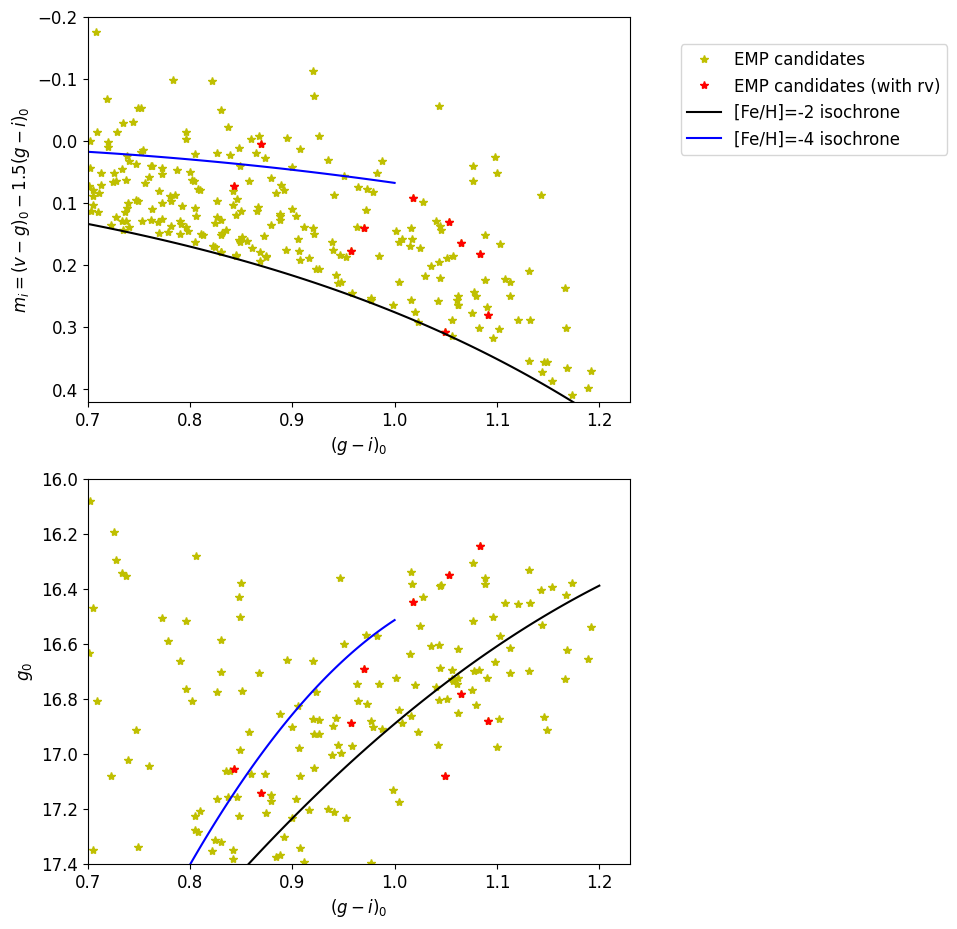

In [8]:
fig, axs = plt.subplots(2,figsize=(7,11))
axs[0].plot(res['g_i0'][cut],res['metallicity'][cut],'y*',label='EMP candidates')
axs[0].plot(res_with_rv['g_i0'][cut_with_rv],res_with_rv['metallicity'][cut_with_rv],'r*',label='EMP candidates (with rv)')
axs[0].plot(x_iso_2,FeH_2_mi,'k-',label='[Fe/H]=-2 isochrone')
axs[0].plot(x_iso_4,FeH_4_mi,'b-',label='[Fe/H]=-4 isochrone')
axs[0].set_xlim(0.7,1.23)
axs[0].set_ylim(0.42,-0.2)
axs[0].set_ylabel('$m_{i} = (v − g)_0 − 1.5(g − i)_0$')
axs[0].set_xlabel('$(g - i)_0$')
axs[0].legend(loc='upper right',bbox_to_anchor=(1.6,0.95))
axs[1].plot(res['g_i0'][cut],res['g0'][cut],'y*',label='EMP candidates')
axs[1].plot(res_with_rv['g_i0'][cut_with_rv],res_with_rv['g0'][cut_with_rv],'r*',label='EMP candidates (with rv)')
axs[1].plot(x_iso_2,FeH_2_g,'k-',label='[Fe/H]=-2 isochrone')
axs[1].plot(x_iso_4,FeH_4_g,'b-',label='[Fe/H]=-4 isochrone')
axs[1].set_xlim(0.7,1.23)
axs[1].set_ylim(17.4,16.0)
axs[1].set_ylabel('$g_0$')
axs[1].set_xlabel('$(g - i)_0$')
plt.show()

*Top:* Metallicity-sensitive diagram of our Magellanic EMP candidates where $m_{i}$ is the metallicity-sensitive index defined as: $m_{i} = (v − g)_0 − 1.5(g − i)_0$. The blue and black curves represent $[Fe/H] = −4$ and $[Fe/H] = −2$ Dartmouth isochrones for an age of 12.5 Gyr and $[\alpha/Fe]=0.4$ ([Dotter et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJS..178...89D/abstract)). Both isochrones have been calibrated with reference to the SkyMapper DR3 data as described in [Da Costa et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.489.5900D/abstract). The upper (positive) bound on the metallicity index selection was set by the location of the $[Fe/H] = -2$ Dartmouth isochrone for an age of 12.5 Gyr and $[\alpha/H]=0.4$ ([Dotter et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJS..178...89D/abstract)). The red stars represent the 10 EMP candidates that have a radial velocity (rv) value from APOGEE-2. Compare this with Figure 1 in Oh et al. 2023.

*Bottom:* CMD with the same description as above. $g_{0}$ is the g-band magnitude that has been dereddened using E(B-V) derived from OGLE-IV reddening maps ([Skowron et al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJS..252...23S/abstract)). The isochrones have been shifted in distance modulus by 18.5 to match the LMC distance.

# Radial velocity vs. position angle
Here we compare the radial velocity values of our EMP candidates and the Oh et al. 2023 EMP candidates. We extracted the position angle and radial velocity values from Oh et al. 2023 as well as [Reggiani et al. 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....162..229R/abstract) and we put them in a Pandas Dataframe object.

In [9]:
oh_cands = pd.DataFrame(
            {'angle': [-0.1,43.7,13.3,34.9,-31.2,-0.5,-66.0,2.8,-17.4,-70.2],
             'rv': [312.0,352.9,289.5,283.6,286.5,269.3,232.1,284.6,229.7,307.4]})
reggiani_cands = pd.DataFrame(
            {'angle': [-68.121,-66.779,-33.445,-18.456,-16.667,-13.311,-13.311,-7.9418,76.846],
             'rv': [265.04,308.54,186.21,356.45,335.63,303.86,298.52,265.68,319.63]})

In [10]:
# Equation for LMC rotation model from van der Marel+2002
x_rots = np.linspace(-200,150,100)
rots = 7e-10*(x_rots**5) + 1e-07*(x_rots**4) - 6e-05*(x_rots**3) - 0.0061*(x_rots**2) + 1.2142*(x_rots) + 288.47

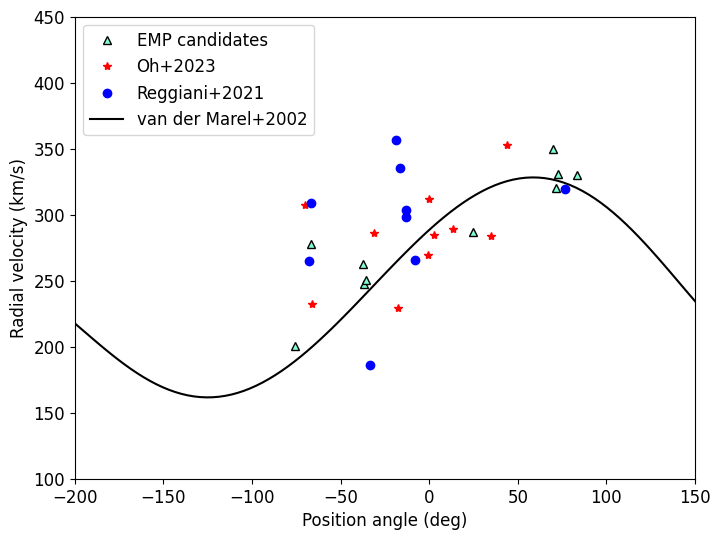

In [11]:
plt.figure(figsize=(8,6))
plt.plot(res_with_rv['angle'][cut_with_rv],res_with_rv['hrv'][cut_with_rv],'^',color='aquamarine',markeredgecolor='black',label='EMP candidates')
plt.plot(oh_cands['angle'],oh_cands['rv'],'r*',label='Oh+2023')
plt.plot(reggiani_cands['angle'],reggiani_cands['rv'],'bo',label='Reggiani+2021')
plt.plot(x_rots,rots,'k-',label='van der Marel+2002')
plt.xlim(-200,150)
plt.ylim(100,450)
plt.ylabel('Radial velocity (km/s)')
plt.xlabel('Position angle (deg)')
plt.legend(loc='upper left')
plt.show()

The Figure shows radial velocity as a function of position angle in the LMC (measured east of north) for our 10 EMP LMC candidates (marked with green triangles). The EMP targets from [Reggiani et al. 2021](https://ui.adsabs.harvard.edu/abs/2021AJ....162..229R/abstract) and from Oh et al. 2023 are also plotted for reference. The black sinusoid shows the LMC rotation model derived from carbon stars in the outer LMC disc ([van der Marel et al. 2002](https://ui.adsabs.harvard.edu/abs/2002AJ....124.2639V/abstract)) that sit at radii similar to the majority of our EMP sample. Compare this plot with Figure 3 in Oh et al. 2023.

# Resources and references

Da Costa et al. (2019) "The SkyMapper DR1.1 search for extremely metal-poor stars", [MNRAS](https://academic.oup.com/mnras/article/489/4/5900/5568381), 489, 5900: https://ui.adsabs.harvard.edu/abs/2019MNRAS.489.5900D/abstract

Dotter et al. (2008) "The Dartmouth Stellar Evolution Database", [ApJS](http://dx.doi.org/10.1086/589654), 178, 89: https://ui.adsabs.harvard.edu/abs/2008ApJS..178...89D/abstract

Oh et al. (2023) "The SkyMapper search for extremely metal-poor stars in the Large Magellanic Cloud", [MNRAS](https://academic.oup.com/mnras/article/524/1/577/7216506), 542, 577: https://ui.adsabs.harvard.edu/abs/2023MNRAS.524..577O/abstract

Reggiani et al. (2021) "The Most Metal-poor Stars in the Magellanic Clouds Are r-process Enhanced", [AJ](http://dx.doi.org/10.3847/1538-3881/ac1f9a), 162, 229: https://ui.adsabs.harvard.edu/abs/2021AJ....162..229R/abstract

Skowron et al. (2021) "OGLE-ing the Magellanic System: Optical Reddening Maps of the Large and Small Magellanic Clouds from Red Clump Stars", [ApJS](https://iopscience.iop.org/article/10.3847/1538-4365/abcb81), 252, 23, https://ui.adsabs.harvard.edu/abs/2021ApJS..252...23S/abstract

van der Marel et al. (2002) "New Understanding of Large Magellanic Cloud Structure, Dynamics, and Orbit from Carbon Star Kinematics", [AJ](http://dx.doi.org/10.1086/343775), 124, 2639: https://ui.adsabs.harvard.edu/abs/2002AJ....124.2639V/abstract

Wolf et al. (2018) "SkyMapper Southern Survey: First Data Release (DR1)", [Publ. Astron. Soc. Aust.](http://dx.doi.org/10.1017/pasa.2018.5), 35, e010: https://ui.adsabs.harvard.edu/abs/2018PASA...35...10W/abstract